---
title: "Eaton and Palisades Fires: Mapping the Environmental and Social Impacts"
description: "Analyzing wildfire extent and the proportion of elderly population affected by the 2025 Eaton and Palisades fires"
author:
  - name: Aakriti Poudel
    url: https://aakriti-poudel-chhetri.github.io/
date: 2025-11-29
format:
  html:
    code-fold: true
    embed-resources: true
jupyter: python3    
citation: 
  url: https://aakriti-poudel-chhetri.github.io/posts/2025-12-eaton-palisades-fires-eji/
categories: [MEDS, geospatial, python, eji]
image: eaton-palisades-fires.png
draft: false
---

##### Link to the GitHub repository: https://github.com/aakriti-poudel-chhetri/la-fire-environmental-social-impact

# About this blog post

In January 2025, the Eaton and Palisades fires ignited almost simultaneously in the foothills and coastal wildland–urban interface zones of Los Angeles County, triggered by anomalously dry conditions and strong Santa Ana winds in Los Angeles County, California. These concurrent events burned more than 38 000 acres and destroyed over 16 000 structures resulting in around 30 direct fatalities and mass evacuations affecting more than 150, 000 individuals.

**Environmental Impact:** The Eaton and Palisades fires had profound environmental consequences across terrestrial, atmospheric and aquatic systems. Air quality deteriorated sharply, with PM2.5 concentrations exceeding 400 µg/m³, contributing to a prolonged hazardous air quality episode that extended far beyond the immediate burn zones. The combustion of built structures released complex mixtures of pollutants, including fine particulates and heavy metals such as lead, raising concerns about toxic exposures both outdoors and within impacted neighborhoods. Post‑fire runoff mobilized ash, sediment and chemical pollutants into waterways, contributing to soil and water contamination altering nutrient cycling and disrupting aquatic ecosystems. These severe environmental impacts shows  how urban wildfires are  interconnected, especially when fires consume both natural vegetation and human-made materials.

**Social Impact:** The social impacts of the January 2025 wildfires were extensive and unevenly distributed. Beyond widespread property damage and environmental degradation, these events disproportionately affected socially vulnerable populations, including low-income households, older adults, renters, and individuals with limited access to healthcare and transportation. Delays in evacuation, long exposure to smoke, losing homes, and disruptions to basic services made existing social and health problems worse. Community groups and public services struggled to meet the rising demand for emergency help, housing and mental health support. These fires show that urban wildfire risk is not just an environmental problem but it is also a common social issue, affected by inequalities that shape who is exposed, how well people can cope, and how they recover.

## Purpose
This analysis combines the environmental monitoring with social vulnerability data to show how the Eaton and Palisades fires affected both the natural landscape and the communities living within it.

## Highlights

The analysis illustrates Python-based approaches for geospatial investigation:

-   Use `xarray` and `rioxarray` to create false-color images from Landsat 8 SWIR, NIR, and Red bands, revealing burn scars.
-   Combine raster satellite data with vector layers (fire perimeters and census tracts) in `geopandas` to integrate multiple data sources.
-   Maintain spatial accuracy by managing coordinate reference systems with `rio.write_crs()` and `to_crs()`.
-   Perform environmental justice analysis by using spatial joins and clipping to examine socioeconomic vulnerability in the burn-affected areas.

## About the data

### Dataset description and source

#### Simplified collection of bands from the Landsat Collection 2 Level-2
This dataset is a simplified collection of bands (red, green, blue, near-infrared and shortwave infrared) from the Landsat Collection 2 Level-2 atmospherically corrected surface reflectance data, collected by the Landsat 8 satellite. The data was retrieved from the [Microsoft Planetary Computer data catalogue](https://planetarycomputer.microsoft.com/dataset/landsat-c2-l2) and clipped to an area surrounding the fire perimeters.

#### Fire perimeters for the Eaton and Palisades fires
This dataset is dissolved fire perimeters/boundaries for Eaton and Palisades fires. The data can be accessed from the [County of Los Angeles Open Data](https://data.lacounty.gov/maps/ad51845ea5fb4eb483bc2a7c38b2370c/about).

#### Environmental Justice Index (EJI) data
The EJI data is extracted from [Centers for Disease Control and Prevention and Agency for Toxic Substances Disease Registry](https://atsdr.cdc.gov/place-health/php/eji/eji-data-download.html)). It provides information on census tract-level demographic and socioeconomic data. This study uses the 2024 California EJI dataset to look at the racial makeup of communities affected by fires, based on the proportion of minority populations.

### References
*Landsat Collection 2 Level-2*. Microsoft Planetary Computer. Retrieved 15 Nov, 2025. https://planetarycomputer.microsoft.com/dataset/landsat-c2-l2.

*Palisades and Eaton Dissolved Fire Perimeters*. (2025) County of Los Angeles Open Data. https://data.lacounty.gov/maps/ad51845ea5fb4eb483bc2a7c38b2370c/about.

*Why Is That Forest Red and That Cloud Blue?*. (2014, March 4). NASA Earth Observatory. https://earthobservatory.nasa.gov/features/FalseColor.

*What Are the Band Designations for the Landsat Satellites?*.(2025, July 11). U.S. Geological Survey. https://www.usgs.gov/faqs/what-are-band-designations-landsat-satellites.

*Common Landsat Band Combinations*. (2021, November 12). U.S. Geological Survey. https://www.usgs.gov/media/images/common-landsat-band-combinations

*Centers for Disease Control and Prevention, and Agency for Toxic Substances and Disease Registry*. (2024) Environmental Justice Index. https://atsdr.cdc.gov/place-health/php/eji/eji-data-download.html.

# Set up, import datasets and explore

##### Load all necessary libraries required for the data analysis.

In [47]:
# Import required libraries
import os
import numpy as np
import pandas as pd
import xarray as xr
import rioxarray as rxr
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as cx

# Analysis 1: Visualizing fire scars through false color image

## Import fire perimeters, NetCDF data and EJI data

In [48]:
# Load fire perimeter datasets
eaton = gpd.read_file("data/Eaton_Perimeter_20250121/Eaton_Perimeter_20250121.shp")
palisades = gpd.read_file("data/Palisades_Perimeter_20250121/Palisades_Perimeter_20250121.shp")

# Load the Landsat data
landsat = xr.open_dataset("data/landsat8-2025-02-23-palisades-eaton.nc")

# Load census tract-level socioeconomic data
eji = gpd.read_file("data/EJI_2024_California/EJI_2024_California.gdb")

## Explore fire perimeters datasets

Fire perimeter data define the spatial extent of the fires, enabling focused analysis on the most impacted areas. Each dataset includes polygon geometries representing the fire boundaries, along with corresponding area and perimeter measurements

First, let's explore the properties and characteristics of both fire perimeter datasets.

In [49]:
# Side-by-side dataset information comparison
comparison_info = {
    'Property': [
        'No. of rows',
        'No. of columns',
        'Column names',
        'Missing values',
        'CRS',
        'CRS type',
        'Geometry type',
    ],
    'Eaton Fire': [
        len(eaton),
        len(eaton.columns),
        ', '.join(eaton.columns.tolist()),
        eaton.isnull().sum().sum(),
        eaton.crs.to_string(),
        'Projected' if eaton.crs.is_projected else 'Geographic',
        eaton.geometry.type.unique()[0]],
    'Palisades Fire': [
        len(palisades),
        len(palisades.columns),
        ', '.join(palisades.columns.tolist()),
        palisades.isnull().sum().sum(),
        palisades.crs.to_string(),
        'Projected' if palisades.crs.is_projected else 'Geographic',
        palisades.geometry.type.unique()[0]]
}

comparison_table = pd.DataFrame(comparison_info)
comparison_table

,Property,Eaton Fire,Palisades Fire
0,No. of rows,20,21
1,No. of columns,5,5
2,Column names,"OBJECTID, type, Shape__Are, Shape__Len, geometry","OBJECTID, type, Shape__Are, Shape__Len, geometry"
3,Missing values,0,0
4,CRS,EPSG:3857,EPSG:3857
5,CRS type,Projected,Projected
6,Geometry type,Polygon,Polygon


**Description of Eaton and Palisades dataset:** The eaton and palisades datasets both have 5 columns (`OBJECTID`, `type`, `Shape_Are`, `Shape_Len` and `geometry`) with the same data types. The data types used are appropriate for all values in their respective columns. There is no missing data in the column. There are 20 rows in `eaton` dataset and 21 rows in `palisades` dataset.

Both of the dataset has same `CRS (EPSG:3857)`, which is **projected coordinate system** that uses the Mercator projection to display the spherical Earth on a flat map.

### Explore NetCDF dataset

##### We will first check the dataset dimensions and summary.

In [50]:
# Check the NetCDF dataset
landsat

<xarray.Dataset> Size: 78MB
Dimensions:      (y: 1418, x: 2742)
Coordinates:
  * y            (y) float64 11kB 3.799e+06 3.799e+06 ... 3.757e+06 3.757e+06
  * x            (x) float64 22kB 3.344e+05 3.344e+05 ... 4.166e+05 4.166e+05
    time         datetime64[ns] 8B ...
Data variables:
    red          (y, x) float32 16MB ...
    green        (y, x) float32 16MB ...
    blue         (y, x) float32 16MB ...
    nir08        (y, x) float32 16MB ...
    swir22       (y, x) float32 16MB ...
    spatial_ref  int64 8B ...

**Description of NetCDF dataset:** Landsat dataset is a remote sensing raster dataset loaded as `xarray.Dataset`. The dataset gives an information on dimensions, coordinates and data variables. There are two spatial dimensions in the dataset: (y: 1418) represents the vertical spatial dimension (rows) and (x: 2742) represents the horizontal spatial dimension (columns).

The dataset has coordinate arrays for both x and y, stored as float64 values that corresponds to their respective spatial map coordinates. There is a only one time coordinate stored as datetime64\[ns\], that indicates when the image was taken.

There are five different spectral bands: red, green, blue, nir08 and swir22, and they have the same pixel grid (float32). A spatial_ref variable is also included to store the map projection information.

##### Now, we will check the CRS of the NetCDF dataset.

In [51]:
# Check CRS of NetCDF dataset
print(f"Current CRS: {landsat.rio.crs}")

Current CRS: None


We can see that if we try to extract the information on CRS directly, CRS isn't automatically recognized by rioxarray, showing it as "None" even though it exists in the `spatial_ref` variable's metadata. We extract the CRS information from `spatial_ref.crs_wkt` and apply it using `.rio.write_crs()` to make it accessible through the `.rio accessor`. This ensures the dataset's geospatial information is properly loaded and ready for spatial operations and mapping.

In [52]:
# Recover the geospatial information and spatial reference information
print(landsat.rio.write_crs(landsat.spatial_ref.crs_wkt, inplace=True))

# Print CRS again
print(f"Current CRS: {landsat.rio.crs}")

<xarray.Dataset> Size: 78MB
Dimensions:      (y: 1418, x: 2742)
Coordinates:
  * y            (y) float64 11kB 3.799e+06 3.799e+06 ... 3.757e+06 3.757e+06
  * x            (x) float64 22kB 3.344e+05 3.344e+05 ... 4.166e+05 4.166e+05
    time         datetime64[ns] 8B ...
    spatial_ref  int64 8B 0
Data variables:
    red          (y, x) float32 16MB ...
    green        (y, x) float32 16MB ...
    blue         (y, x) float32 16MB ...
    nir08        (y, x) float32 16MB ...
    swir22       (y, x) float32 16MB ...
Current CRS: EPSG:32611


## RGB True Color Image Analysis

A true-color image is created by mapping the visible red, green and blue Landsat bands to their corresponding RGB channels. When plotted together, these bands produce an image that closely resembles what the human eye would see from space. This makes true color images especially useful for visually identifying landscape features such as vegetation, urban areas water bodies and cloud cover.

To generate the image, red, green and blue bands are selected directly from the existing `xarray.Dataset` without creating new variables. These bands are then combined into a NumPy array using the `to_array()` method and displayed as an RGB image using `.plot.imshow()`.

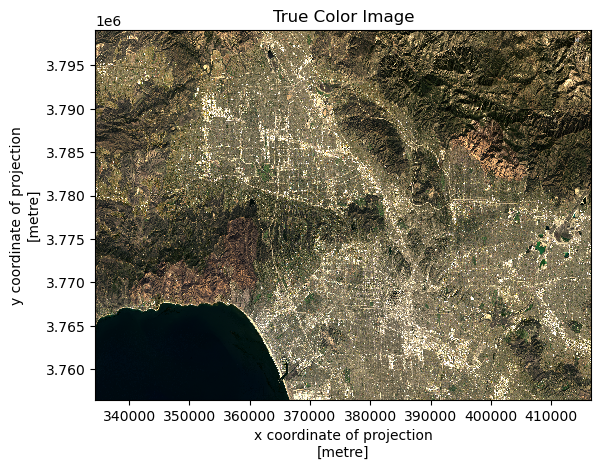

In [53]:
# Initialize the map
fig, ax = plt.subplots()

# # Plot true color image with NaNs filled and robust scaling
landsat[['red', 'green', 'blue']].fillna(value=0).to_array().plot.imshow(robust=True)

plt.title("True Color Image")
plt.show()

When plotting a true color image, warnings may appear due to extreme values and missing data in the dataset. Extreme pixel values can dominate the color scaling and reduce image contrast, therefore we use `robust=True` during plotting. Additionally, some bands may contain missing (NaN) values, which interfere with visualization. Replacing missing values before plotting removes warnings and allows the color scale to adjust more smoothly, producing a cleaner and more interpretable image.

## False Color Image Analysis

A false-color image is created by selecting the short-wave infrared (SWIR2), near-infrared and red bands, in that order, directly from the dataset and plotting them together as an RGB image.

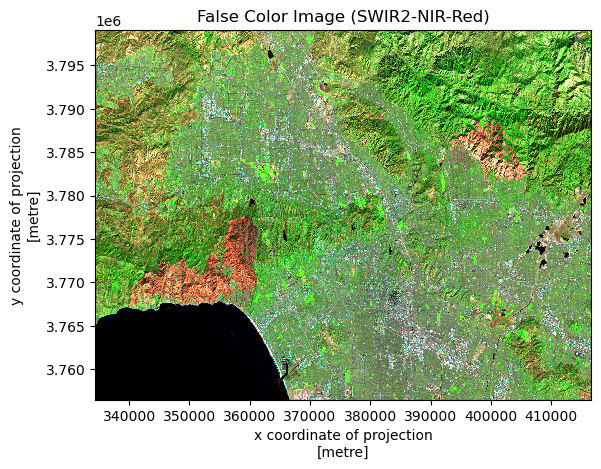

In [54]:
# Create false color image (SWIR2, NIR, Red)
landsat[['swir22', 'nir08', 'red']].to_array().plot.imshow(robust = True)
plt.title('False Color Image (SWIR2-NIR-Red)')
plt.show()

### False color image for Eaton and Palisades fires

We plot a false-color image using the shortwave infrared, near-infrared and red bands, and overlay both fire perimeters on top of it.

In [55]:
# Combine the two fire perimeter datasets into a single GeoDataFrame
fires = pd.concat([eaton, palisades], ignore_index = True)

# Convert CRS of the Eaton and Palisades fire perimeter to landsat dataset CRS
fires = fires.to_crs('epsg:32611')

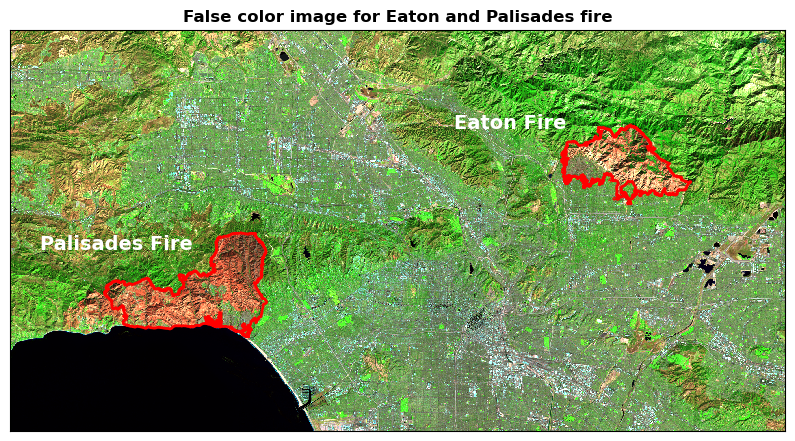

In [56]:
# Initialize the map
fig, ax = plt.subplots(figsize = (10, 8))

# Plot the false color map
landsat[['swir22', 'nir08', 'red']].to_array().plot.imshow(robust = True,
                                                           ax = ax,
                                                           add_colorbar = False)

# Plot fires perimeter on false color map
fires.boundary.plot(ax = ax, color = 'red', linewidth = 2)

# Add text for first fire (adjust index and name as needed)
ax.text(fires.geometry.centroid.x.values[0] - 11000, fires.geometry.centroid.y.values[0] + 8000, 'Eaton Fire',
        fontsize = 14, weight = 'bold', color = 'white', ha = 'center', va = 'center')

# Add text for second fire (adjust index and name as needed)
ax.text(fires.geometry.centroid.x.values[-1] - 9000, fires.geometry.centroid.y.values[-1] + 5000, 'Palisades Fire', 
        fontsize = 14, weight = 'bold', color = 'white', ha = 'center', va= 'center')

# Add title to the map
plt.title('False color image for Eaton and Palisades fire', fontsize = 12, weight = 'bold')

# Remove axes ticks
ax.set_xticks([])  
ax.set_yticks([])  

# Remove axes labels
ax.set_xlabel("")  
ax.set_ylabel("")

# Add a scalebar
#ax.add_artist(ScaleBar(1, box_color="white",location="lower left"))

plt.show()

##### Summary on how false color imagery is being used

This map shows a false color image made from Landsat data for Eaton and Palisades fire of the Los Angeles County. The map uses three bands: SWIR2, NIR and Red, assigned to the red, green and blue color channels. In this image, vegetation looks green because they reflect a lot of near-infrared light. The fire burned areas and bare ground looks brown. The urban areas usually appear purple or gray. The water looks black. The boundaries of the Eaton Fire and Palisades fire are delineated with red outlines. Each fire is labeled.

This combination of bands is useful for spotting burn scars and understanding fire damage because SWIR2 reacts strongly to moisture changes, and NIR highlights how healthy the vegetation is. Together, these bands make it easy to see where fires have changed the landscape.

# Analysis 2: Social dimensions of Eaton and Palisades fires

The Environmental Justice Index (EJI) highlights the social dimensions of wildfire impacts, revealing how vulnerable communities are disproportionately affected. These maps provide clear visualizations of factors such as age, health, and economic vulnerability, helping to identify populations most at risk and the underlying patterns of environmental injustice in each county.

##### We begin by verifying that the CRS of the EJI dataset matches the fire perimeters and Landsat data to ensure spatial compatibility for our analysis.

In [57]:
# Convert CRS of `eji` to match eaton and palisades perimeter data
eji = eji.to_crs(crs = 'epsg:3857')

## Spatial join

We combine EJI data with the Eaton and Palisades fire perimeters to analyze the social dimensions of fire impacts. First, a spatial join `gpd.sjoin` gives all EJI polygons that intersect each fire, keeping full census tracts that are affected. Next, the `gpd.clip` function trims these polygons to the exact area within the fire boundaries, allowing for precise calculations of vulnerability metrics confined to the burned regions.

In [58]:
# Spatially join the EJI data with the palisades
palisades_eji = gpd.sjoin(eji, palisades, how = "inner")
eaton_eji = gpd.sjoin(eji, eaton, how = "inner")

# Clip the census tracts to the Palisades fire perimeter
palisades_clip = gpd.clip(eji, palisades)
eaton_clip = gpd.clip(eji, eaton)

## Visualizations of the social impacts of fires

The social dimension of wildfire risk is closely tied to population vulnerability, particularly among elderly residents. Therefore, here we will visulaize the proportions of the elderly resident aged 65 and above, and discuss why this is important for disaster recovery and response preparedness. In the EJI data, the percentage of populations aged 65 and older are indicated as 'E_AGE65'.

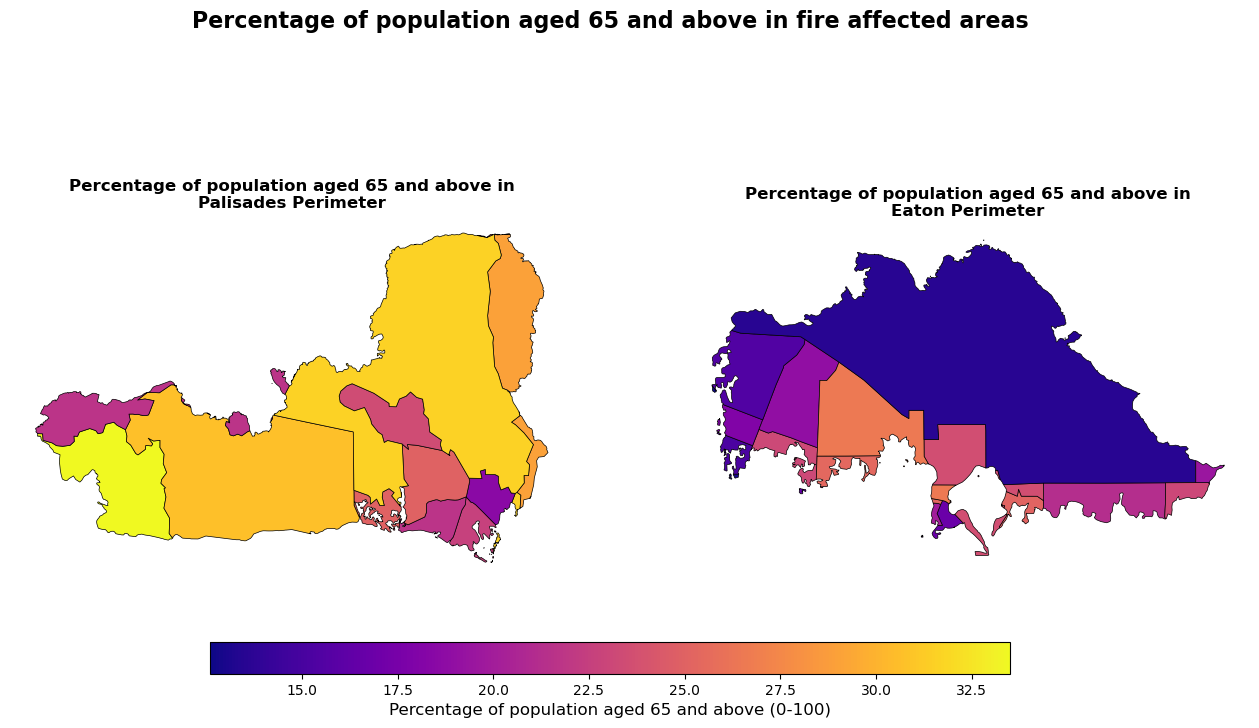

In [59]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

# Update with the eji variable
eji_variable = 'E_AGE65'

# Find common min/max for legend range
vmin = min(palisades_clip[eji_variable].min(), eaton_clip[eji_variable].min())
vmax = max(palisades_clip[eji_variable].max(), eaton_clip[eji_variable].max())

# Plot census tracts within Palisades perimeter
palisades_clip.plot(column= eji_variable, cmap='plasma', vmin=vmin, vmax=vmax, legend=False, ax=ax1, edgecolor='black', linewidth=0.5)
ax1.set_title('Percentage of population aged 65 and above in\nPalisades Perimeter',
              fontsize=12, fontweight='bold')
ax1.axis('off')

# Plot census tracts within Eaton perimeter
eaton_clip.plot(column=eji_variable, cmap='plasma', vmin=vmin, vmax=vmax, legend=False, ax=ax2, edgecolor='black', linewidth=0.5)
ax2.set_title('Percentage of population aged 65 and above in\nEaton Perimeter',
              fontsize=12, fontweight='bold')
ax2.axis('off')

# Add overall title
fig.suptitle('Percentage of population aged 65 and above in fire affected areas',
             fontsize=16, fontweight='bold')

# Add shared colorbar at the bottom
sm = plt.cm.ScalarMappable(cmap='plasma', norm=plt.Normalize(vmin=vmin, vmax=vmax))
cbar_ax = fig.add_axes([0.25, 0.15, 0.5, 0.04])  # [left, bottom, width, height]
cbar = fig.colorbar(sm, cax=cbar_ax, orientation='horizontal')
cbar.set_label('Percentage of population aged 65 and above (0-100)',
               fontsize=12)

plt.show()


##### Importance of social vulnerability assessment in wildfire response
This analysis shows significant demographic differences between the Eaton and Palisades fire affected areas. The Palisades fire perimeter contains a notably higher percentages of elderly residents, aged 65 and above. The study of this demographic pattern  is important for emergency response planning, as older adults face unique wildfire vulnerabilities including limited mobility, chronic health conditions and reduced evacuation capacity. Disaster relief strategies in the Palisades area should prioritize interventions such as assisted evacuations, accessible medical services, and elder specific community outreach programs. The Eaton fire perimeter, with its lower elderly population concentration, may benefit from resource allocation focused on other demographic vulnerabilities. Understanding these spatial demographic patterns is essential for developing equitable and effective wildfire preparedness, and  response and recovery strategies that address the specific needs of vulnerable communities.